# 0. Preliminaries

   ## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from IPython.display import HTML as html_print
import seaborn as sns    # for heatmaps

import logomaker         # if not present install with: pip install logomaker

## Parameters of the problem

In [98]:
# These are global variables to be used throughout the notebook
num_sequences = 50
sequence_length = 100
motif_length = 8
alpha = 1 # this alpha is used when estimating the motif

## Initialize the random number generator

In [ ]:
random_seed = 2023
rng = np.random.default_rng(random_seed)

# 1. Generate the data

## Functions to generate and view a motif
We will represent the motif by a list length K of probability distributions over [0..3]

In [114]:
def sample_motif(motif_length=motif_length, alpha=0.1):
    """
    Create a motif from the dirichlet distribution
    """
    return rng.dirichlet([alpha]*4, motif_length) # fill using rng.dirichlet() 

def draw_motif(motif, title="", ax=None):
    """
    Draw a logo of the motif with logomaker
    """
    # Make dataframe for logomake
    df = pd.DataFrame(motif, columns=["A", "C", "G", "T"])
    df = logomaker.transform_matrix(df, from_type="probability", to_type="information")
    logo = logomaker.Logo(df, ax=ax)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore") 
        logo.ax.set_title(title)
        # logo.ax.set_xlabel("Position")
        logo.ax.set_ylabel("Total information")
        logo.ax.set_ylim(0, np.log2(4))
        logo.fig.show()
        

## Test out motif generation
Get the next cell to run yourself, by fixing the code in sample_motif() function above, then explore what happens as you vary alpha, e.g. to 0.5, 1, 5, perhaps 0.01. Try each value several times.

In [ ]:
M = sample_motif(alpha = 0.1)
# print out the motif nicely
with np.printoptions(precision=3, suppress=True):
    print(M)
# draw the logo for the motif - we will use this function below to visualise motifs
draw_motif(M)

## Next we generate some example instances from a motif
The motifs we just made are probalistic models of sequences of length K.  Here we generate several examples of our current motif.  First you need to fill in the missing code in the function definition in the next cell, and run this to define the function. Then you can explore using it to sample instances of the motif. Try this with motifs made with different values of alpha (obtained by re-running the cell above with the desired value of alpha). Motifs made with smaller values of alpha should create more conserved sets of sample instances.

In [ ]:
def sample_sequence_from_motif(motif):
    """
    Sample an instance of the motif from the distribution defined by the motif
    """
    # Initialize the sequence array
    motif_sequence = np.zeros(motif_length, dtype=int)

    # Draw each sequence element from motif
    for k in range(motif_length):
        motif_sequence[k] = rng.choice(4, size=1, p=motif[k, :]) # fill using rng.choice() 

    return motif_sequence

In [ ]:
for i in range(10):
    seq = sample_sequence_from_motif(M)
    for s in seq:
        print ("ACGT"[s], end='')
    print()

## Now generate a set of sequences that each incorporate one copy of the motif

In [ ]:
def generate_sequences(motif):
    """
    Sample a set of sequences, with a single instance of the motif 
    embedded at a random position in each sequence
    """        
    # Initialize the sequences matrix with random bases
    sequences = rng.integers(4, size=(num_sequences, sequence_length))

    # Draw positions for motifs
    positions = rng.integers(sequence_length - motif_length + 1, size=num_sequences)

    # Per full sequence, draw from motif and insert
    for n in range(num_sequences):
        sequences[n, positions[n]:positions[n]+motif_length] = sample_sequence_from_motif(motif) # replace the subsequence of length motif_length at positions[n] with a motif instance
            
    return sequences, positions


def cstr(s, color='black'):
    return "<text style='color:{};font-family:monospace;font-size:1em'>{}</text>".format(color, s)

def draw_sequences(sequences, positions=None):
    """
    Show the sequences in nice text, optionally highlighting the motif positions in red
    """
    text = ""
    for n in range(len(sequences)):
        row = ""
        for s in sequences[n]:
            row += "ACGT"[s]
        row += "\n"
        
        # If no positions to show, everything is black
        if positions is None:                  
            row = cstr(row, color='black')
    
        # Otherwise, color in red
        else:
            pos = positions[n]
            row = \
                cstr(row[:pos], color="black") + \
                cstr(row[pos:pos+motif_length], color="red") + \
                cstr(row[pos+motif_length:], color="black")
        
        text += row
    
    display(html_print(text))


In [ ]:
sequences, positions = generate_sequences(M)
draw_sequences(sequences[:20], positions)  # use without positions to show without highlighting

# 2. Expectation-Maximization
First we define the key set of functions to calculate the overall log likelihood, the posteriors of the positions given the sequences (expectation step), the new parameter values given the posteriors (maximisation step).  Then the function to iterate the steps to run the EM algorithm, and a function to draw the results so we can see what happened.

## Calculate log-likelihood of data

In [ ]:
def log_likelihood(sequences, motif):
    """
    Calculate the log-likehood of the sequences given the motif, 
    integrating over all positions.
    """
    # Initialize
    ll = 0.0
    max_position = sequence_length - motif_length + 1
    constant_part = (1.0 / max_position) * (1.0/4)**(sequence_length - motif_length)
    
    # Per sequence, add the log-likelihood
    for n in range(num_sequences):
        pseq = 0.0
        for i in range(max_position):
            # add to pseq the probability of sequence n with motif at position i (several lines needed)
            part = constant_part
            for k in range(motif_length):
                part *= motif[k, sequences[n, i + k]] 
            pseq += part
        ll += np.log(pseq)
                        
    return ll
        

## Expectation step

In [ ]:
def expectation_step(sequences, motif):
    """
    Calculate the posterior probabilities of the motif being at each position in each sequence
    """
    # Initialize
    max_position = sequence_length - motif_length + 1
    positions_posterior = np.zeros((num_sequences, max_position), dtype=float)
    
    # Per sequence, calculate the posterior
    for n in range(num_sequences):
        # Calculate the likelihood of each k-mer in the sequence 
        for i in range(max_position):
            likelihood = 1.0
            for k in range(motif_length):
                likelihood *= motif[k, sequences[n, i + k]] # update the joint likelihood for position k in the motif
            positions_posterior[n, i] = likelihood
            
        # Normalize the posteriors for sequence n to sum to 1
        positions_posterior[n, :] /= positions_posterior[n, :].sum()
        
    return positions_posterior
    

## Maximization step

In [ ]:
def maximization_step(sequences, positions_posterior):
    """
    Re-estimate the motif by summing expected counts using the posterior from the expectation_step
    """
    # Initialize
    max_position = sequence_length - motif_length + 1
    motif_estimate = np.zeros((motif_length, 4), dtype=float)   
    
    # Add dirichlet prior
    motif_estimate += alpha
    
    # Build the estimate
    for k in range(motif_length):
        for n in range(num_sequences):
            for i in range(max_position):
                # Which nucleotide is in the k-th position of the i-th k-mer 
                # in the n-th sequence?
                j = sequences[n, i+k]
                
                # Update the respective estimate
                motif_estimate[k, j] += positions_posterior[n, i]
                
        motif_estimate[k, :] /= motif_estimate[k, :].sum() # Normalize the motif_estimates at k to sum to 1
        
    return motif_estimate
        
    

## EM algorithm

In [ ]:
def expectation_maximization(sequences, n_iterations, print_every=None, parallel=False):
    """
    search for a maximum likelihood motif estimate by alternating expectation_ and maximisation_ steps
    return the estimated motif, and the log likelihoods, position distributions and motifs at each step
    """
    # Initialize the motif estimate randomly
    if parallel:
        est_motif = np.random.default_rng().random(size=(motif_length, 4)) # so as to get random starts
    else:
        est_motif = rng.random(size=(motif_length, 4)) # this way things are pseudorandom predictable
    est_motif /= est_motif.sum(axis=1)[:, np.newaxis]
    
    # Iterate E and M steps
    lls = []
    positions_posteriors = []
    motifs = []
    for n_iter in range(n_iterations):
        # Print current log-likelihood
        ll = log_likelihood(sequences, est_motif)
        lls.append(ll)
        if (print_every is not None) and (n_iter % print_every == 0):
            print(f"Iteration {n_iter}: LL = {ll}")
        
        # E step
        positions_posterior = expectation_step(sequences, est_motif)
        positions_posteriors.append(positions_posterior)
        
        # M step
        est_motif = maximization_step(sequences, positions_posterior)
        motifs.append(est_motif)
    
    return est_motif, lls, positions_posteriors, motifs

## Plot results

In [ ]:
def plot_results(iters,est_motif,lls,posteriors,motifs):
    print (f"LL with true motif {log_likelihood(sequences,M)}")
    print (f"LL with final estimated motif {log_likelihood(sequences,est_motif)}")
       
    # plot the true and final estimated motifs
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    draw_motif(M,ax=axs[0])
    axs[0].set_title("True motif")
    draw_motif(est_motif,ax=axs[1])
    axs[1].set_title("Final estimated motif")
    
    if lls is not None:
        # plot the log likelihoods
        plt.figure()
        plt.plot(lls)
        plt.xlabel("# of iteration")
        plt.ylabel("log likelihood")
    
    # plot heatmaps of the motif locations at given iterations
    if len(iters) > 0 and posteriors is not None:
        fig, axs = plt.subplots(1, len(iters), figsize=(20, 8))
        for ax, n_iter in zip(axs, iters):
            sns.heatmap(posteriors[n_iter][:,:], ax=ax, vmin=0, vmax=1);
            ax.set_title(f"Iteration # {n_iter}")
            ax.set_ylabel("Sequence #")
            ax.set_xlabel("Position")
    
    # and below them the motifs
    if len(iters) > 0 and motifs is not None:
        fig, axs = plt.subplots(1, len(iters), figsize=(20, 2))
        for ax, n_iter in zip(axs, iters):
            draw_motif(motifs[n_iter],ax=ax)

## Run it!

In [ ]:
est_motif, lls, positions_posteriors, motifs = expectation_maximization(sequences, 100, print_every=10)

In [ ]:
plot_results([0,10,20,50],est_motif,lls,positions_posteriors,motifs)

### Try running the following cell several times. In what ways does the output vary, and why?

In [ ]:
plot_results([], *expectation_maximization(sequences, 50, print_every=10))

### Now lets try making different motifs, with different prior Dirichlet alpha
What seem to be constraints on the ability to find the motif?

In [ ]:
M = sample_motif(alpha = 0.2)       # try alpha = 0.2, 0.5, 1, perhaps even more
# if it hasn't converged correctly you could try generating more sequences by uncommenting/changing the next line
# num_sequences = 100
sequences, positions = generate_sequences(M)
# and if it hasn't converged by 50 iterations you could increase the number 50 in the next line
est_motif, lls, positions_posteriors, motifs = expectation_maximization(sequences, 50, print_every=10)
plot_results([], est_motif, lls, positions_posteriors, motifs)

# 3. Monte-Carlo Markov Chain (MCMC)
As before we first define the necessary functions, with you having to fill in some missing fields to ensure that you read the code and understand what is being done.

In [ ]:
def log_likelihood_with_positions(sequences, positions, motif):

    # Initialize
    ll = 0.0
    max_position = sequence_length - motif_length + 1
    
    # Per sequence, add the log-likelihood
    for n in range(num_sequences):
        p = 0.0
        i = positions[n]
        q = 1
        for k in range(motif_length):
            q *= motif[k, sequences[n, i + k]] 
        p += q
        ll += np.log(p)
                        
    return ll

In [ ]:
def gibbs_sample_position(sequences, est_motif):

    max_position = sequence_length - motif_length + 1

    # Draw new positions
    positions_posterior = expectation_step(sequences, est_motif)
    positions = np.zeros(len(sequences), dtype=int)
    for n in range(num_sequences):
        positions[n] = rng.choice(max_position, p=positions_posterior[n]) # fill in the distribution used to select the position
        
    return positions


In [ ]:
def calculate_posterior_dirichlet_parameters(alpha, sequences, positions, motif_length):

    max_position = sequence_length - motif_length + 1
    
    # Calculate the posterior dirichlet parameters
    posterior_parameters = np.ones((motif_length, 4), dtype=float) * alpha    
    for k in range(motif_length):
        for n in range(num_sequences):
            a = sequences[n, positions[n] + k]
            posterior_parameters[k,a] += 1            
    
    return posterior_parameters
    

In [ ]:
def gibbs_sample_motif(alpha, sequences, est_positions, motif_length):

    max_position = sequence_length - motif_length + 1
    
    # Calculate the dirichelt parameters
    dirichlet_parameters = calculate_posterior_dirichlet_parameters(alpha, sequences, est_positions,motif_length)
    
    # Draw new motif from this distribution
    est_motif = np.zeros((motif_length, 4), dtype=float)
    for k in range(motif_length):
        est_motif[k, :] = rng.dirichlet(dirichlet_parameters[k]) # fill in the parameter set to sample from
        
    return est_motif
    

In [ ]:
def metropolis_hastings_step(sequences, est_positions, est_motif, current_ll, max_position):

    # Make new state
    if rng.random() < 0.5:
        # abcdefgh -> habcdefg
        new_motif = np.roll(est_motif, 1, axis=0)
        new_positions = (est_positions - 1) % max_position
    else:
        # abcdefgh -> bcdefgha
        new_motif = np.roll(est_motif, -1, axis=0)
        new_positions = (est_positions + 1) % max_position
        
    # Calculate likelihood of new state
    new_ll = log_likelihood_with_positions(sequences, new_positions, new_motif)
    
    # Acceptance ratio
    acceptance_ratio = min(1.0, np.exp(new_ll - current_ll))
    
    # Accept if needed
    if rng.random() < acceptance_ratio:
        return new_motif, new_positions, True
    else:
        return est_motif, est_positions, False
        

In [ ]:
def mcmc_sampling(sequences, motif_length, alpha, n_iterations, with_shifts=False, print_every=None):

    # Initialize the motif estimate randomly
    est_motif = rng.random(size=(motif_length, 4))
    est_motif /= est_motif.sum(axis=1)[:, np.newaxis]
    
    # Initialize positions
    max_position = sequence_length - motif_length + 1
    est_positions = rng.integers(max_position, size=num_sequences)
        
    # MCMC iterations
    lls = []
    motifs = []
    all_shifted = []
    for n_iter in range(n_iterations):
        # Print current log-likelihood
        motifs.append(est_motif)
        ll = log_likelihood_with_positions(sequences, est_positions, est_motif)
        lls.append(ll)
        if (print_every is not None) and (n_iter % print_every == 0):
            print(f"Iteration {n_iter}: LL = {ll}")
            
        # Draw new positions
        est_positions = gibbs_sample_position(sequences, est_motif)
        
        # Draw new motif
        est_motif = gibbs_sample_motif(alpha, sequences, est_positions, motif_length)
        
        # Possible shift
        if with_shifts:
            est_motif, est_positions, shifted = metropolis_hastings_step(sequences, est_positions, est_motif,
                                                                         ll, max_position)
            all_shifted.append(shifted)
        
    return est_motif, lls, motifs
    

## Run it several times, both with shifts off (default) and shifts on
How do these results compare with the EM solutions?

Look carefully at the log_likelihood values for the final solution. How are the final estimated motifs and their likelihoods different from those obtained by EM?

What happens when we allow shift operations using Metropolis-Hastings?

How does the number of iterations required compare with EM? What might be sensible numbers for the burn-in period and for taking random samples from the Markov chain? 

Maybe it would be interesting to try MCMC with a variety of motifs made with different values of alpha (remember to sample new sequences also when you make a new motif M).

In [ ]:
est_motif, lls, motifs = mcmc_sampling(sequences, motif_length, alpha, 500, with_shifts=False, print_every=50)
plot_results([0,50,100,200,400],est_motif, lls, None, motifs)

In [ ]:
M = sample_motif(alpha = 0.2)       # try alpha = 0.2, 0.5, 1, perhaps even more
# if it hasn't converged correctly you could try generating more sequences by uncommenting/changing the next line
# num_sequences = 100
sequences, positions = generate_sequences(M)

# 4. Real data
Here we will explore a real data set of 200 promoter sequences identified in [Serizay et al. (2020)](https://genome.cshlp.org/content/30/12/1752.long) as being active in genes with tissue-specific expression in the intestine of the nematode *C. elegans*.

In [133]:
# First we upload the data set
# pip install biopython
from Bio import SeqIO

fasta_sequences = SeqIO.parse(open("elegans_intestine.WS235.fa"),'fasta')

sequences = []
for fasta in fasta_sequences:
    s = str(fasta.seq)
    table = s.maketrans('ACGT','0123')
    s = s.translate(table)
    s = np.array(list(s)).astype(int)
    sequences.append(s)

sequences = np.array(sequences)
num_sequences, sequence_length = sequences.shape
print("num_sequences", num_sequences, "sequence_length", sequence_length)

num_sequences 200 sequence_length 151


## Now we can run our EM program
Try running it several times.

It is likely that you will get different outcomes. This is because with real data there may be more than one pattern present, unlike in our simulations. Also unlike in our simulations, in real data the background model of a simple 0.25 probability per base is clearly over-simplified.

Iteration 0: LL = -41854.04638013117
Iteration 10: LL = -41596.55853410053
Iteration 20: LL = -41582.34125429639
Iteration 30: LL = -41575.67500269136
Iteration 40: LL = -41573.70603961705


Text(0, 0.5, 'log likelihood')

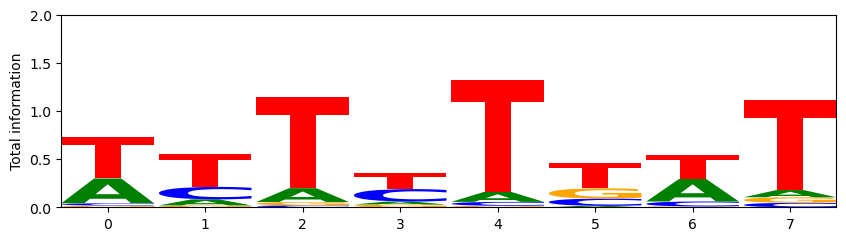

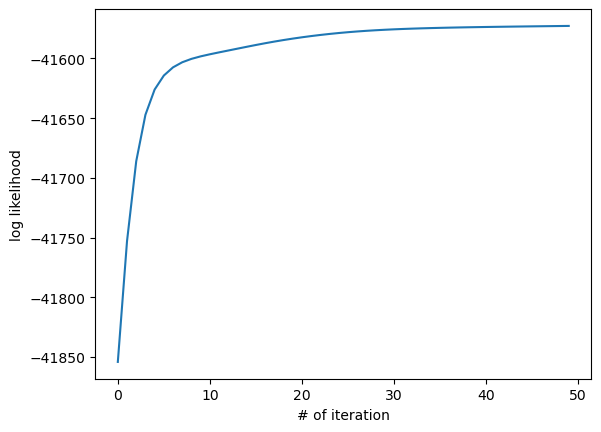

In [144]:
# now we can run our EM algorithm
# try running this several times
est_motif, lls, positions_posteriors, motifs = expectation_maximization(sequences, 50, print_every=10)
draw_motif(est_motif)
plt.figure()
plt.plot(lls)
plt.xlabel("# of iteration")
plt.ylabel("log likelihood")


## Parallel search for high scoring motifs
Because different random starts given different results, we will run 20 jobs in parallel, then sort the results by score.

You need to wait until you see "Done 20 out of 20" in order for all the jobs to finish, before sorting and printing in the next cell.  How many run at once depends on the computer you are working on.

How many fundamentally different patterns do you find?

In [145]:
# to find the top matches, run EM 20 times and sort the results by the log likelihood

import joblib

results = joblib.Parallel(n_jobs=-1,verbose=100)(   # this uses all available cores to parallelise
    joblib.delayed(expectation_maximization)(sequences, 31, print_every=10, parallel=True)
        for i in range(20)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:   10.1s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:   10.2s remaining:   57.6s
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:   10.2s remaining:   40.8s
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:   10.3s remaining:   31.0s
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:   10.4s remaining:   24.2s
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:   10.4s remaining:   19.3s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   10.4s remaining:   15.6s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:   10.4s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   10.5s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   19.3s remaining:   15.8s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapse

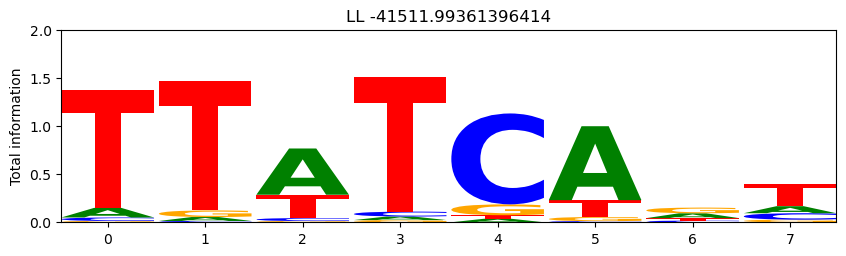

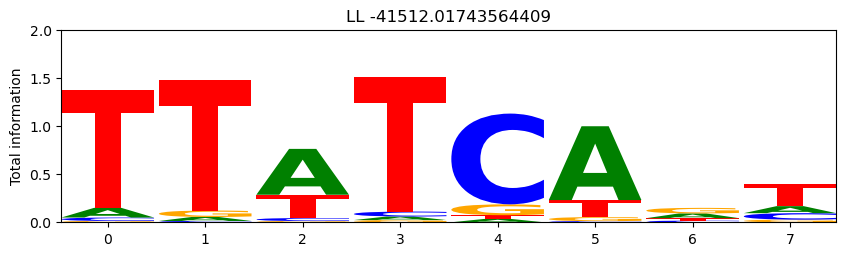

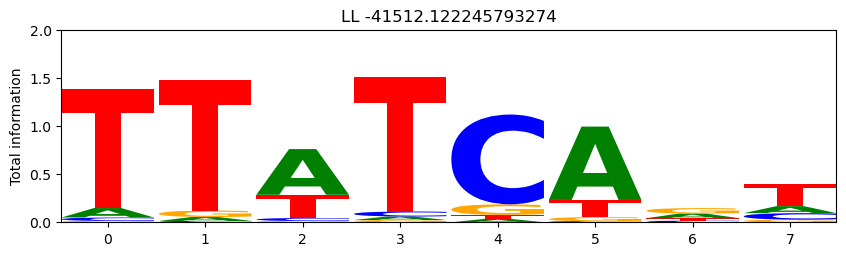

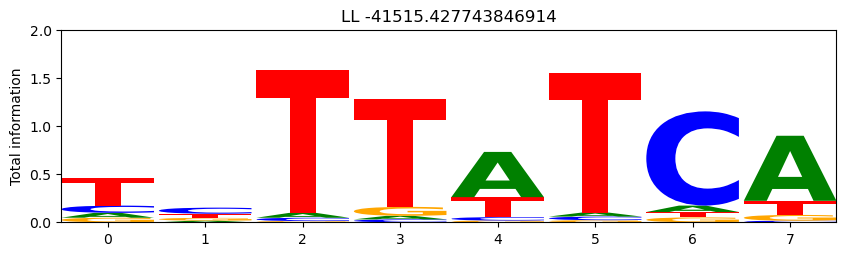

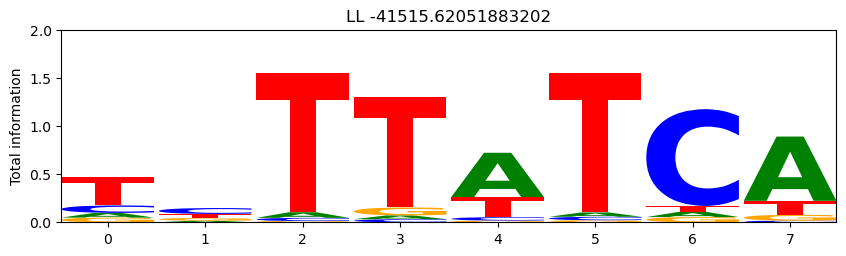

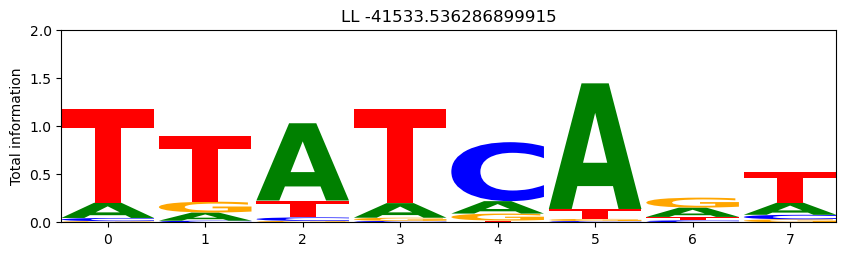

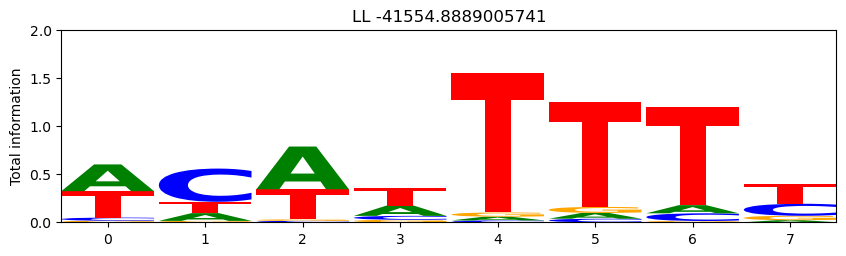

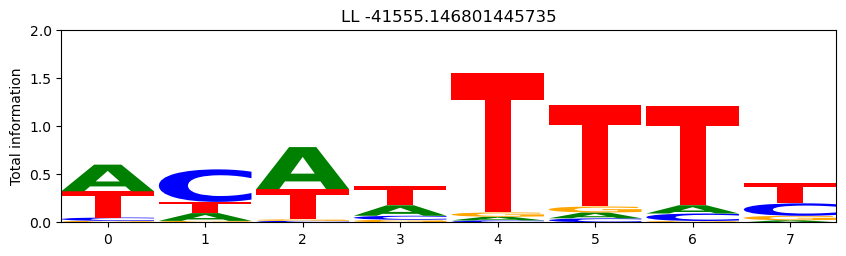

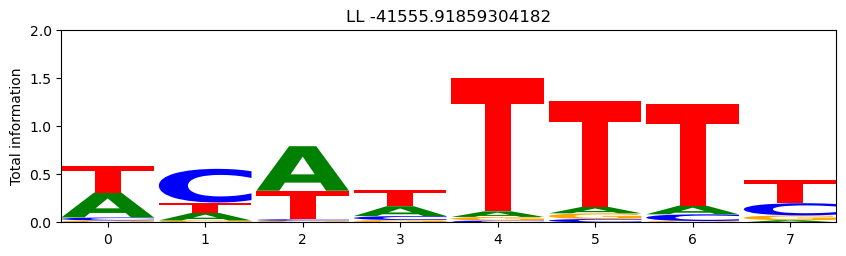

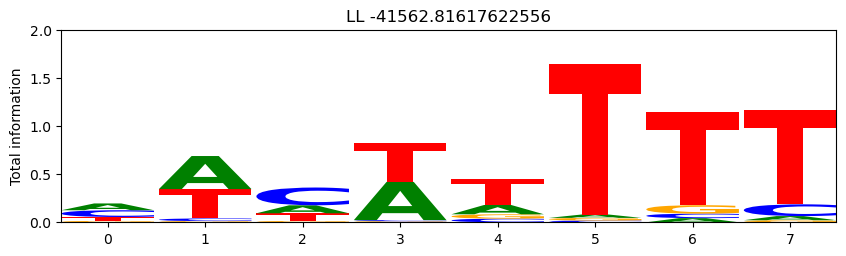

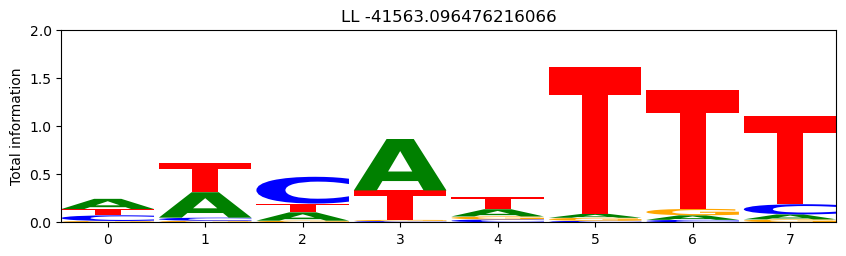

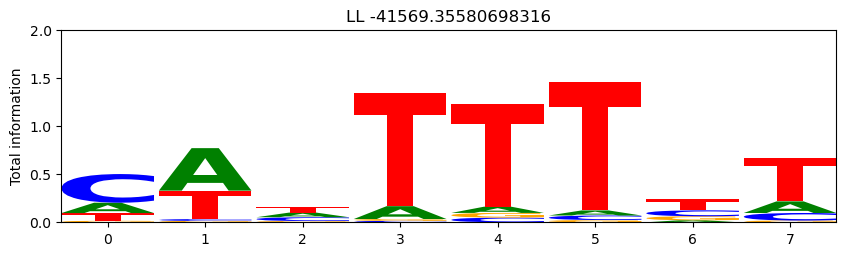

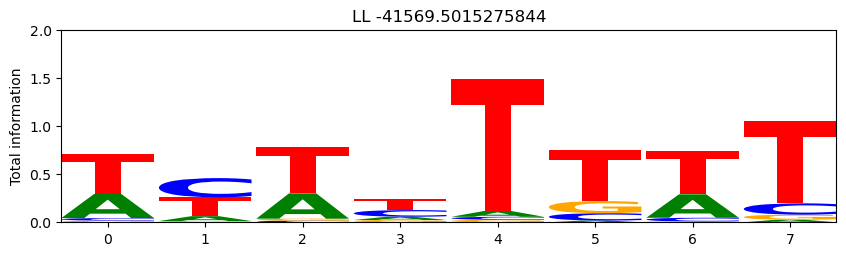

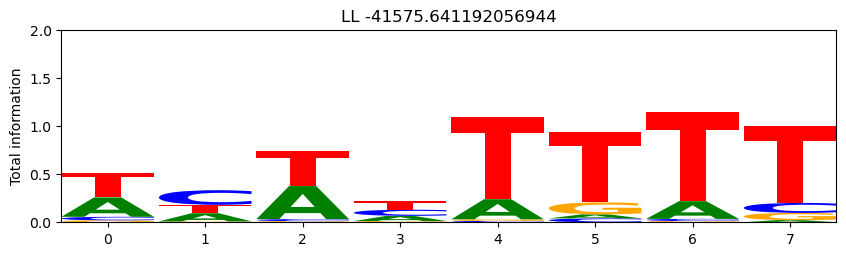

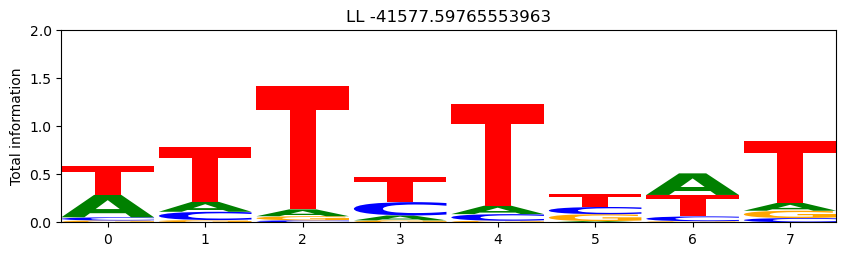

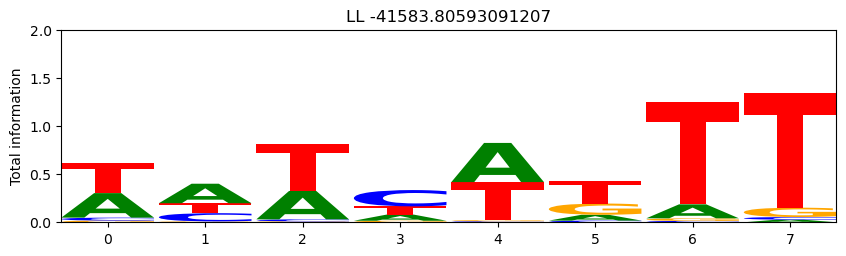

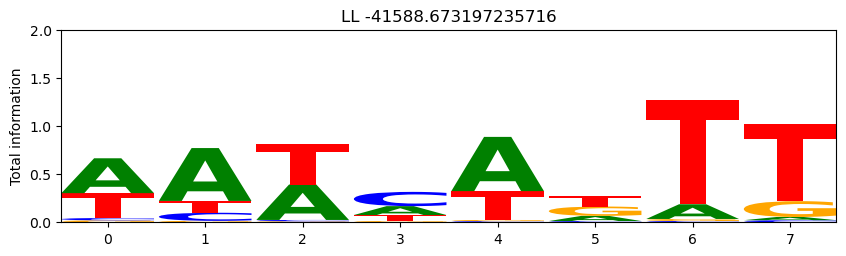

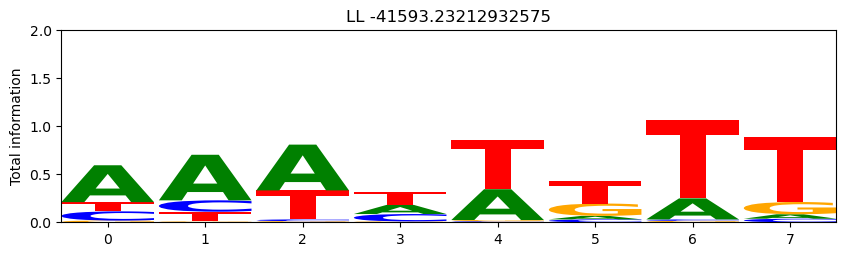

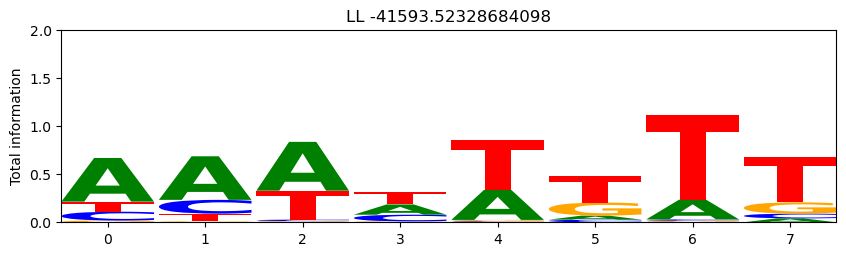

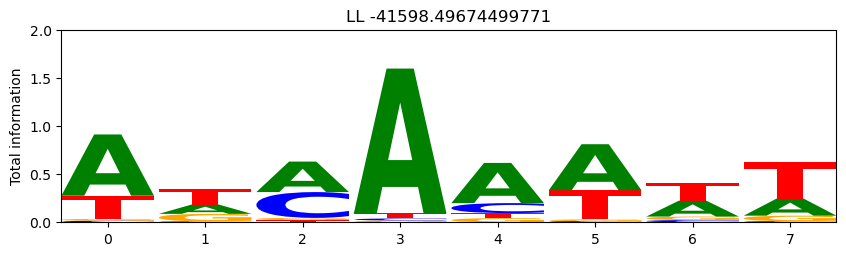

In [146]:
# store just the final log likelihoods and motifs in list LLmotif, then sort

LLmotif = []
for R in results:
    LLmotif.append([R[1][-1],R[0]])  # the final log likelihood and the motif
from operator import itemgetter
LLmotif.sort(key=itemgetter(0), reverse=True)
for x in LLmotif:
    draw_motif(x[1], title=f"LL {x[0]}")

## Compare to MEME

This is [a link to the output of a MEME run](https://meme-suite.org/meme//opal-jobs/appMEME_5.5.016744305844412056779887/meme.html) on the same sequences, using default parameters in the OOPS (One Occurrence Per Sequence) mode.

Are there similarities, or differences, between your high scoring motifs and the ones found by MEME? You should note that MEME is much more sophisticated, searching both strands, with a background model that it learns from the data.

## Search in the JASPAR database using Tomtom

The [JASPAR](https://jaspar.genereg.net/) database contains a curated set of previously established binding motif patterns for hundreds of transcription factors and species, including *C.elegans*.

You can search it to find known patterns similar to motifs you have found using another program in the MEME suite, [TomTom](https://meme-suite.org/meme/tools/tomtom). 

To load your motifs found in from the worm intestine practical into TomTom, you need to first write it out as a 
    
What does your lead pattern correspond to?  Remember that the sequence you obtain may be the reverse complement of what MEME finds (it searches both strands).

In [168]:
def write_MEME_file(motifs, file_name="MCB.meme", motif_name="MCB"):
    with open(file_name,'w') as f:
        # write header
        f.write("MEME version 5.5.0\n\n")
        f.write("ALPHABET= ACGT\n\n")
        f.write("strands: + -\n\n")
        # write motifs
        count = 0
        for m in motifs:
            count = count + 1
            f.write(f"MOTIF {motif_name}-{count}\n\n")
            f.write(f"letter-probability matrix: alength= 4 w= {motif_length}\n")
            np.savetxt(f, m, delimiter=' ', fmt='%.4f')
            f.write("\n")
        f.close()
    print(len(motifs), "motifs written")

In [169]:
write_MEME_file([LLmotif[0][1], LLmotif[8][1]]) # list here the motifs you want

2 motifs written


## Search in TomTom
* go to the [TomTom submission link](https://meme-suite.org/meme/tools/tomtom)
* upload the file you have just written (called MCB.meme, unless you renamed it)
* select the "JASPAR (NON-REDUNDANT) DNA" target motif database
* select the "JASPAR CORE (2022) nematodes", unless you want to search all species, in which case leave it as "JASPAR CORE"
* tick the "Search with one motif (faster queue)" box
* press "Start search"

What do you find?

##Another promoter region file
If you enjoyed that, and have time left, there is another file you can try, containing 200 promoter sequences from musce